# Setup
This IPython notebook will walk through the steps of characterizing iModulons through the semi-automated tools in PyModulon. You will need:

* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [1]:
from pymodulon.core import IcaData
from pymodulon.plotting import *
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

In [2]:
# Enter the location of your data here
data_dir = path.join('..','data','5g_processed_data')
ica_data_dir = path.join('..','data','5g_interim')

# GO and KEGG annotations are in the 'external' folder
external_data = path.join('..','data','external')

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [3]:
df_metadata = pd.read_csv(path.join(data_dir,'final_meta.tsv'),sep='\t')
df_metadata.head()

,sample_id,exp_theme,exp_condition,sample,shortd,longd,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode,include?,notes,cluster_id,project,condition,reference_condition
0,5GB1_FM03_TR1_QC_tpm,uMax,uMax,5GB1_FM03_TR1_QC,uMax_QC,"Fermentor run 3, uMax though close to O2 limit...",2,1,0,3,0,2,0,1,NaN,1,5G,uMax,uMax
1,5GB1_FM03_TR2_QC_tpm,uMax,uMax,5GB1_FM03_TR2_QC,uMax_QC,"Fermentor run 3, uMax though close to O2 limit...",2,1,0,3,0,2,0,1,NaN,3,5G,uMax,uMax
2,5GB1_FM11_TR1_QC_tpm,lowO2_fast_growth,lowO2_fast_growth,5GB1_FM11_TR1_QC,lowO2_QC,"Fermentor run 11, O2 limited, QC",2,0,0,3,0,1,0,1,NaN,18,5G,lowO2_fast_growth,uMax
3,5GB1_FM11_TR2_QC_tpm,lowO2_fast_growth,lowO2_fast_growth,5GB1_FM11_TR2_QC,lowO2_QC,"Fermentor run 11, O2 limited, QC",2,0,0,3,0,1,0,1,NaN,18,5G,lowO2_fast_growth,uMax
4,5GB1_FM12_TR1_tpm,lowCH4,lowCH4,5GB1_FM12_TR1,lowCH4,"Fermentor run 12, methane limited",1,1,0,3,0,1,0,1,NaN,17,5G,lowCH4,uMax


In [4]:
df_metadata.columns

Index(['sample_id', 'exp_theme', 'exp_condition', 'sample', 'shortd', 'longd',
       'carbon_source', 'oxygen_level', 'nitrate_level', 'copper_level',
       'lanthanum_level', 'growth_rate', 'growth_mode', 'include?', 'notes',
       'cluster_id', 'project', 'condition', 'reference_condition'],
      dtype='object')

In [5]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## ~Check your TRN~ - We have no TRN for 5G!

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [6]:
# df_trn = pd.read_csv(path.join(external_data,'TRN.csv'))
# df_trn.head()

In [7]:
#df_trn[df_trn['regulator'] == 'AbrB']

The `regulator` and `gene_id` must be filled in for each row

In [8]:
# print(df_trn.regulator.notnull().all())
# print(df_trn.gene_id.notnull().all())

## Load the data
You're now ready to load your IcaData object!

In [9]:
m = pd.read_csv(path.join(ica_data_dir,'M.csv'))
m.head()

,locus_tag,0,1,2,3,4,5,6,7,8,...,43,44,45,46,47,48,49,50,51,52
0,EQU24_RS00005,-0.001218,-0.012210,-0.000148,0.001630,-0.007975,-0.002027,0.001659,-0.002002,-0.001159,...,0.007620,-0.017961,-0.003422,-0.005579,0.000207,-0.001315,-0.000140,-0.001118,0.005176,-0.000223
1,EQU24_RS00010,-0.000421,-0.016359,-0.008427,0.006276,-0.007272,-0.002388,-0.006465,0.002140,0.002844,...,0.008849,-0.003400,-0.003843,-0.008979,0.004835,0.006598,0.001099,-0.008522,0.007841,0.000336
2,EQU24_RS00015,0.014323,-0.004434,0.001522,0.014076,-0.004344,-0.002314,-0.006279,0.011183,-0.002367,...,0.000502,-0.010556,-0.001445,-0.004536,0.008162,-0.001967,-0.000995,0.006729,-0.001812,0.001697
3,EQU24_RS00020,0.003416,0.001109,0.008821,0.000094,0.000696,0.000544,-0.002481,0.008632,0.000616,...,0.003644,-0.004934,-0.003466,0.000330,-0.003172,0.004194,0.005029,-0.003325,-0.002615,0.007750
4,EQU24_RS00025,0.024772,0.008447,0.006155,0.000959,-0.004074,0.000910,-0.005474,-0.002638,0.002965,...,-0.006944,0.020871,0.001575,-0.003430,-0.007034,0.008026,0.016603,-0.004422,0.008380,0.011851


In [10]:
a = pd.read_csv(path.join(ica_data_dir,'A.csv'))
a.head()

,Unnamed: 0,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,5GB1_FM14_TR1_tpm,...,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-5G-La-BR1_tpm,5GB1C-5G-La-BR2_tpm,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
0,0,9.529850,7.499091,5.468450,5.010820,-5.870309,-5.777901,-10.125820,-10.326414,-1.335729,...,3.508544,3.917175,-1.753262,-3.977450,-3.956464,-4.478062,-0.741869,-1.859980,-2.955320,-3.948350
1,1,0.332269,-0.736224,1.015687,-0.382087,0.998179,1.016328,1.840793,1.650056,-0.647088,...,-2.291153,-2.547193,-11.787137,-10.148064,-12.942754,-5.250938,-8.754121,-12.819043,-4.555001,-16.266555
2,2,0.358727,0.723006,-0.660407,0.284854,-14.235708,-14.269141,-14.105268,-14.393936,-13.349594,...,-6.672029,-5.477086,4.368587,4.047420,4.256874,3.606128,4.391246,4.378823,4.961652,3.977729
3,3,-5.659867,1.427957,2.188699,1.240829,1.770186,1.287521,1.572553,1.125283,1.544704,...,3.870540,2.919166,3.094606,2.251679,3.030040,0.074859,3.538138,3.847606,3.462035,2.261120
4,4,-8.099084,-1.329372,1.478984,0.427919,0.733313,0.889191,0.728142,1.879416,1.258482,...,0.898605,1.313268,4.971210,4.746343,4.872671,5.165037,4.982777,4.976336,5.840944,4.804737


In [11]:
x = pd.read_csv(path.join(data_dir,'5g_log_tpm_norm_indiv.csv'))
x.head()

,locus_tag,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,5GB1_FM14_TR1_tpm,...,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-5G-La-BR1_tpm,5GB1C-5G-La-BR2_tpm,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
0,EQU24_RS00005,-0.081618,0.013543,-1.005473,-0.565908,-0.868240,-0.861181,-0.860286,-0.810841,-0.466774,...,-0.423331,-0.413887,-0.465584,-0.361508,-0.366746,-0.629039,-0.374679,-0.430905,-0.773416,-0.326023
1,EQU24_RS00010,-0.213951,-0.115316,-0.677320,-0.569877,-1.119576,-1.054664,-1.167149,-1.149678,-0.423026,...,-0.179590,-0.182090,-0.479849,-0.274384,-0.346861,-0.306024,-0.388553,-0.356148,-0.679766,-0.170025
2,EQU24_RS00015,0.002850,-0.174656,-0.639651,-0.279816,-1.029608,-1.120098,-1.028006,-0.996256,-0.586234,...,-0.110156,0.045097,-0.655508,-0.483245,-0.609796,-0.620538,-0.578460,-0.572416,-0.801799,-0.181680
3,EQU24_RS00020,-0.130356,0.040745,-0.414605,-0.346534,-0.941858,-0.957353,-0.913985,-0.980052,-0.512366,...,0.082403,0.193677,-0.363136,-0.123069,-0.244925,-0.128927,-0.032470,-0.106898,-0.295688,-0.049523
4,EQU24_RS00025,0.659048,0.404700,-0.031390,0.291903,-0.787794,-0.640604,-0.818610,-0.839456,-0.307450,...,0.087352,0.059120,-0.455537,-0.375085,-0.325837,-0.267183,-0.280655,-0.400990,-0.192058,-0.235679


In [12]:
s = pd.read_csv(path.join(data_dir,'final_meta.tsv'),sep='\t',index_col=0)
s.tail()

,exp_theme,exp_condition,sample,shortd,longd,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode,include?,notes,cluster_id,project,condition,reference_condition
sample_id,,,,,,,,,,,,,,,,,,
5GB1C-5G-N-BR2_tpm,Lanthanum,NoLanthanum,5GB1C-5G-N-BR2,NoLa_rep2,Vial sample in mid- to late-exponential phase,2,1,0,3,0,2,1,1,NaN,12,5G,NoLanthanum,uMax
5GB1C-JG15-La-BR1_tpm,Lanthanum,WithLanthanum,5GB1C-JG15-La-BR1,deltaTBDT_La_rep1,Vial sample in mid- to late-exponential phase,2,1,0,3,1,2,1,1,NaN,12,5G,WithLanthanum,uMax
5GB1C-JG15-La-BR2_tpm,Lanthanum,WithLanthanum,5GB1C-JG15-La-BR2,deltaTBDT_La_rep2,Vial sample in mid- to late-exponential phase,2,1,0,3,1,2,1,1,NaN,12,5G,WithLanthanum,uMax
5GB1C-JG15-N-BR1_tpm,Lanthanum,NoLanthanum,5GB1C-JG15-N-BR1,deltaTBDT_NoLa_rep1,Vial sample in mid- to late-exponential phase,2,1,0,3,0,2,1,1,NaN,12,5G,NoLanthanum,uMax
5GB1C-JG15-N-BR2_tpm,Lanthanum,NoLanthanum,5GB1C-JG15-N-BR2,deltaTBDT_NoLa_rep2,Vial sample in mid- to late-exponential phase,2,1,0,3,0,2,1,1,NaN,12,5G,NoLanthanum,uMax


In [13]:
g = pd.read_csv(path.join(data_dir,'5G_gene_info2.csv'))
g.tail()

,locus_tag,product,type,gene_symbol,locus,start_coord,end_coord,note,translation,gene_len,tu_name,tu_id,gene_name_extra,ncbi_protein,strand,COG,uniprot
4208,EQU24_RS22135,tRNA uridine-5-carboxymethylaminomethyl(34) sy...,CDS,mnmE,NZ_CP035467.1,4994941,4996288,Derived by automated computational analysis us...,VDIGTNDTIAAIATPPGNGGVGIVRISGPAVSIIAAKLTDRPLPPR...,1348,rpmH // rnpA // yidD // yidC // mnmE,1,mnmE||mnmE,WP_017841475.1,-1,J,A0A4P9USW8
4209,EQU24_RS22140,membrane protein insertase YidC,CDS,yidC,NZ_CP035467.1,4996295,4997993,Derived by automated computational analysis us...,MDNIRFILVVTFAMLLYMLYDAWQIDYGPKREISVAQQMPQDLKED...,1699,rpmH // rnpA // yidD // yidC // mnmE,1,yidC||yidC,WP_017841474.1,-1,U,A0A4V1IKE6
4210,EQU24_RS22145,membrane protein insertion efficiency factor YidD,CDS,yidD,NZ_CP035467.1,4997998,4998220,Derived by automated computational analysis us...,MRVLLIAIIKLYQYFISPLLGKNCRFYPSCSCYALEALHKHGAAQG...,223,rpmH // rnpA // yidD // yidC // mnmE,1,yidD||yidD,WP_083877753.1,-1,S,UPI000A004C04
4211,EQU24_RS22150,ribonuclease P protein component,CDS,rnpA,NZ_CP035467.1,4998201,4998570,Derived by automated computational analysis us...,LTNKVFSFPPQLRLRKPSEYKKVFTGPVKSSDAYFTLLAVRNELDH...,370,rpmH // rnpA // yidD // yidC // mnmE,1,rnpA||rnpA,WP_017841473.1,-1,J,A0A4P9UT31
4212,EQU24_RS22155,50S ribosomal protein L34,CDS,rpmH,NZ_CP035467.1,4998574,4998709,Derived by automated computational analysis us...,MKRTYQPSKIKRVRTHGFRARMATKGGRKVLNARRAKGRAKLTV*,136,rpmH // rnpA // yidD // yidC // mnmE,1,rpmH||rpmH,WP_083877752.1,-1,J,UPI00034B9E08


In [14]:
# ERIN: change this to the new M and A?
# ica_data = IcaData(M = path.join(ica_data_dir,'M.csv'),
#                    A = path.join(ica_data_dir,'A.csv'),
#                    X = path.join(data_dir,'5g_log_tpm_norm_indiv.csv'),
#                    gene_table = path.join(data_dir,'5G_gene_info2.csv'),
#                    sample_table = path.join(data_dir,'final_meta.tsv'),
#                    #trn = path.join(external_data,'TRN.csv'),
#                    optimize_cutoff=True)

If you don't have a TRN (or have a very minimal TRN), use `threshold_method = 'kmeans'`

In [15]:
# ERIN: ah, I'll use this version for 5g? bc no TRN

ica_data = IcaData(M = path.join(ica_data_dir,'M.csv'),
                   A = path.join(ica_data_dir,'A.csv'),
                   X = path.join(data_dir,'5g_log_tpm_norm_indiv.csv'),
                   gene_table = path.join(data_dir,'5G_gene_info2.csv'),
                   sample_table = path.join(data_dir,'final_meta.tsv'),
                   #trn = path.join(data_dir,'TRN.csv'),
                   threshold_method = 'kmeans')

In [16]:
ica_data.imodulon_table

""
0
1
2
3
4
5
6
7
8
9


# ~Regulatory iModulons~ I don't have TRN, so skip this
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [17]:
#ica_data.compute_trn_enrichment()

You can also search for AND/OR combinations of regulators using the `max_regs` argument.

Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table.

In [18]:
# First search for regulator enrichments with 2 regulators
# ica_data.compute_trn_enrichment(max_regs=2,save=True)

# # Next, search for regulator enrichments with just one regulator. This will supercede the 2 regulator enrichments.
# ica_data.compute_trn_enrichment(max_regs=1,save=True)

The list of regulatory iModulons are shown below

In [19]:
# regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
# print(len(ica_data.imodulon_table),'Total iModulons')
# print(len(regulatory_imodulons),'Regulatory iModulons')
# regulatory_imodulons

You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

If two iModulons have the same regulator (e.g. 'Reg'), they will be named 'Reg-1' and 'Reg-2'

In [20]:
# ica_data.rename_imodulons(regulatory_imodulons.regulator.to_dict())
# ica_data.imodulon_table.head()

In [21]:
# regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]

# Functional iModulons

GO annotations and KEGG pathways/modules were generated in the 1_create_the_gene_table.ipynb notebook. Enrichments will be calculated in this notebook, and further curated in the 3_manual_iModulon_curation notebook.

## GO Enrichments

First load the Gene Ontology annotations

,locus_tag,gene,product,go_terms
0,EQU24_RS00005,dnaA,chromosomal replication initiator protein DnaA,"['GO:0000166', 'GO:2000112', 'GO:1990837', 'GO..."
1,EQU24_RS00010,NaN,DNA polymerase III subunit beta,"['GO:0009360', 'GO:0016772', 'GO:1990234', 'GO..."
2,EQU24_RS00015,recF,DNA replication/repair protein RecF,"['GO:0003677', 'GO:0033554', 'GO:0009314', 'GO..."
3,EQU24_RS00020,gyrB,DNA topoisomerase (ATP-hydrolyzing) subunit B,"['GO:0000166', 'GO:0006351', 'GO:0003918', 'GO..."
4,EQU24_RS00025,NaN,hypothetical protein,[]


In [43]:
#DF_GO = pd.read_csv(path.join(external_data,'5G_GO_annotations_from_egg.csv'),index_col=0)
DF_GO = pd.read_csv(path.join(external_data,'5G_go_combined_melt.tsv'),sep='\t').fillna("")
print(DF_GO.shape)
DF_GO.head()

(64545, 3)


,locus_tag,go_id,go_name
0,EQU24_RS00005,GO:0000166,nucleotide binding
1,EQU24_RS00005,GO:2000112,regulation of cellular macromolecule biosynthe...
2,EQU24_RS00005,GO:1990837,sequence-specific double-stranded DNA binding
3,EQU24_RS00005,GO:0003677,DNA binding
4,EQU24_RS00005,GO:0008144,


In [44]:
# i think IcaData object needs 'gene_id' column
DF_GO['gene_id'] = DF_GO['locus_tag']
DF_GO.head(15)

,locus_tag,go_id,go_name,gene_id
0,EQU24_RS00005,GO:0000166,nucleotide binding,EQU24_RS00005
1,EQU24_RS00005,GO:2000112,regulation of cellular macromolecule biosynthe...,EQU24_RS00005
2,EQU24_RS00005,GO:1990837,sequence-specific double-stranded DNA binding,EQU24_RS00005
3,EQU24_RS00005,GO:0003677,DNA binding,EQU24_RS00005
4,EQU24_RS00005,GO:0008144,,EQU24_RS00005
5,EQU24_RS00005,GO:0006725,cellular aromatic compound metabolic process,EQU24_RS00005
6,EQU24_RS00005,GO:0080090,regulation of primary metabolic process,EQU24_RS00005
7,EQU24_RS00005,GO:0008152,metabolic process,EQU24_RS00005
8,EQU24_RS00005,GO:0009987,cellular process,EQU24_RS00005
9,EQU24_RS00005,GO:0043170,macromolecule metabolic process,EQU24_RS00005


In [45]:
DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'go_name')

In [46]:
DF_GO_enrich

,imodulon,go_name,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,2,metallo-sulfur cluster assembly,0.000010,0.042997,0.068182,0.600000,0.122449,3.0,5.0,44.0
1,6,transposase activity,0.000005,0.012283,0.250000,0.087719,0.129870,5.0,57.0,20.0
2,6,"transposition, DNA-mediated",0.000006,0.012283,0.250000,0.084746,0.126582,5.0,59.0,20.0
3,8,alcohol dehydrogenase (cytochrome c(L)) activity,0.000002,0.006937,0.333333,1.000000,0.500000,2.0,6.0,6.0
4,8,periplasmic space,0.000043,0.088762,0.500000,0.053571,0.096774,3.0,56.0,6.0
...,...,...,...,...,...,...,...,...,...,...
436,41,leucine biosynthetic process,0.005577,0.092636,0.010309,0.500000,0.020202,3.0,6.0,291.0
437,41,tetrahydrofolate interconversion,0.005577,0.092636,0.010309,0.500000,0.020202,3.0,6.0,291.0
438,41,negative regulation of translational initiation,0.005577,0.092636,0.010309,0.500000,0.020202,3.0,6.0,291.0
439,41,primary active transmembrane transporter activity,0.005954,0.098502,0.020619,0.240000,0.037975,6.0,25.0,291.0


In [39]:
DF_GO_enrich['imodulon'].value_counts()

41    245
9     106
39     47
27     10
2       4
Name: imodulon, dtype: int64

In [47]:
DF_GO_enrich['imodulon'].value_counts()

41    249
9     105
39     48
27     10
32      7
36      4
15      3
22      3
6       2
8       2
17      2
29      2
31      2
2       1
10      1
Name: imodulon, dtype: int64

In [102]:
DF_GO_enrich[DF_GO_enrich['imodulon'] == 15]

,imodulon,go_name,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source
111,15,transposase activity,0.000005,0.014764,0.090909,0.157895,0.115385,9.0,57.0,99.0,GO
112,15,"transposition, DNA-mediated",0.000007,0.014764,0.090909,0.152542,0.113924,9.0,59.0,99.0,GO
113,15,nitrogen fixation,0.000058,0.079286,0.050505,0.263158,0.084746,5.0,19.0,99.0,GO


In [62]:
ica_data.view_imodulon(29)

,gene_weight,product,type,gene_symbol,locus,start_coord,end_coord,note,translation,gene_len,tu_name,tu_id,gene_name_extra,ncbi_protein,strand,COG,uniprot
EQU24_RS00105,-0.031130,cAMP-activated global transcriptional regulato...,CDS,crp,NZ_CP035467.1,24340,24994,Derived by automated computational analysis us...,MTPSKLNPAYRDALEPFLHLCHTKSYPAKTTIIRPGDTGDRLYFII...,655,crp // EQU24_RS00100,2818,crp||crp,WP_014146545.1,-1,K,A0A4P9UID5
EQU24_RS00145,-0.035153,hypothetical protein,CDS,NaN,NZ_CP035467.1,34142,34445,Derived by automated computational analysis us...,MKKLTLILLTGLILQACENAPVRREEMISEHPEWDKEMVEVIKAGY...,304,EQU24_RS00155 // EQU24_RS00150 // EQU24_RS00145,2812,||None,WP_014146553.1,-1,J,A0A4P9UL47
EQU24_RS00190,0.038314,hypothetical protein,CDS,NaN,NZ_CP035467.1,42656,42884,Derived by automated computational analysis us...,LPVEGSDELKQTNEIGMFIPVIDTLADIADKTITGDALLTQRKLAH...,229,EQU24_RS00195 // EQU24_RS00190,2805,||None,WP_138767047.1,-1,-,UPI00110D139D
EQU24_RS00195,0.033967,DUF4338 domain-containing protein,CDS,NaN,NZ_CP035467.1,42874,43876,Derived by automated computational analysis us...,MKAHHYLGALPKIGHTLWYVASYHNQWLALISFSAAAWKCAARDQW...,1003,EQU24_RS00195 // EQU24_RS00190,2805,||None,WP_235726418.1,-1,L,NaN
EQU24_RS00205,0.049202,IS66 family transposase,CDS,NaN,NZ_CP035467.1,44526,46077,Derived by automated computational analysis us...,MDTDYLDDLPEGELRPLSKQLLADLKEARERLKQSPDTSSRPPSSR...,1552,EQU24_RS00205,2803,||None,WP_244310896.1,-1,L,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS21750,-0.057395,DUF3450 domain-containing protein,CDS,NaN,NZ_CP035467.1,4904690,4905464,Derived by automated computational analysis us...,MFLTCRFSKALAGVTVLFLSAGAYSDPLNQAIDTDLATNKAAVDSQ...,775,EQU24_RS21750 // EQU24_RS21745 // EQU24_RS2174...,50,||None,WP_017841551.1,-1,D,A0A4P9UXK0
EQU24_RS21760,-0.037305,amidohydrolase,CDS,NaN,NZ_CP035467.1,4906513,4907704,Derived by automated computational analysis us...,MAIHWEQLIQNAVAFRHTLHQKPELSWQEQETAQRIRNELSRLGIA...,1192,EQU24_RS21760,48,||doeB2,WP_017841549.1,1,S,A0A4P9USQ2
EQU24_RS21865,0.032338,type II toxin-antitoxin system HicB family ant...,CDS,NaN,NZ_CP035467.1,4931344,4931812,Derived by automated computational analysis us...,MKTLKYKDYEGTCEIDAEEEICYGKLLFIDDLITYEAEAPKQLRQE...,469,EQU24_RS21870 // EQU24_RS21865 // EQU24_RS21860,39,||None,WP_017841529.1,1,S,A0A4P9USZ2
EQU24_RS21910,-0.033401,MotA/TolQ/ExbB proton channel family protein,CDS,NaN,NZ_CP035467.1,4942188,4943358,Derived by automated computational analysis us...,MNMKFWFVLCLALALAPFAQAETEAVLTPPELETRLDEELAAKAAL...,1171,EQU24_RS21915 // EQU24_RS21910 // EQU24_RS21905,33,||None,WP_235726420.1,-1,U,NaN


In [63]:
DF_GO_enrich.sort_values('pvalue')#.head()

,imodulon,go_name,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
192,41,translation,3.596113e-34,1.475485e-30,0.178694,0.500000,0.263291,52.0,104.0,291.0
193,41,structural constituent of ribosome,5.880405e-33,1.206365e-29,0.130584,0.703704,0.220290,38.0,54.0,291.0
195,41,ribosomal subunit,5.238442e-32,5.373332e-29,0.130584,0.678571,0.219020,38.0,56.0,291.0
194,41,cytosolic ribosome,5.238442e-32,5.373332e-29,0.130584,0.678571,0.219020,38.0,56.0,291.0
196,41,peptide biosynthetic process,2.924840e-31,2.400124e-28,0.164948,0.494845,0.247423,48.0,97.0,291.0
...,...,...,...,...,...,...,...,...,...,...
436,41,leucine biosynthetic process,5.576652e-03,9.263565e-02,0.010309,0.500000,0.020202,3.0,6.0,291.0
437,41,tetrahydrofolate interconversion,5.576652e-03,9.263565e-02,0.010309,0.500000,0.020202,3.0,6.0,291.0
438,41,negative regulation of translational initiation,5.576652e-03,9.263565e-02,0.010309,0.500000,0.020202,3.0,6.0,291.0
439,41,primary active transmembrane transporter activity,5.953820e-03,9.850212e-02,0.020619,0.240000,0.037975,6.0,25.0,291.0


## KEGG Enrichments

### Load KEGG mapping
The `kegg_mapping.csv` file contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [64]:
DF_KEGG = pd.read_csv(path.join(external_data,'5G_kegg_mapping.csv'),index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
3758,EQU24_RS00005,KEGG_pathway,map02020
3759,EQU24_RS00005,KEGG_pathway,map04112
3766,EQU24_RS00010,KEGG_pathway,map00230
3767,EQU24_RS00010,KEGG_pathway,map00240
3768,EQU24_RS00010,KEGG_pathway,map01100


In [65]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [66]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [67]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,8,map00680,0.000002,0.000381,0.666667,0.051948,0.096386,4.0,77.0,6.0
1,8,map00625,0.000047,0.005965,0.333333,0.250000,0.285714,2.0,8.0,6.0
2,8,map01120,0.000284,0.023921,0.666667,0.013937,0.027304,4.0,287.0,6.0
3,8,map00010,0.001042,0.065929,0.333333,0.055556,0.095238,2.0,36.0,6.0
4,9,map04212,0.000004,0.000942,0.187500,0.333333,0.240000,3.0,9.0,16.0


In [68]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,8,M00174,0.000153,0.051911,0.333333,0.142857,0.200000,2.0,14.0,6.0
1,10,M00641,0.000008,0.001348,0.035294,1.000000,0.068182,3.0,3.0,85.0
2,10,M00642,0.000008,0.001348,0.035294,1.000000,0.068182,3.0,3.0,85.0
3,10,M00769,0.000031,0.003543,0.035294,0.750000,0.067416,3.0,4.0,85.0
4,10,M00245,0.000402,0.017100,0.023529,1.000000,0.045977,2.0,2.0,85.0


### Convert KEGG IDs to human-readable names

In [69]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

In [70]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,8,map00680,0.000002,0.000381,0.666667,0.051948,0.096386,4.0,77.0,6.0,Methane metabolism
1,8,map00625,0.000047,0.005965,0.333333,0.250000,0.285714,2.0,8.0,6.0,Chloroalkane and chloroalkene degradation
2,8,map01120,0.000284,0.023921,0.666667,0.013937,0.027304,4.0,287.0,6.0,Microbial metabolism in diverse environments
3,8,map00010,0.001042,0.065929,0.333333,0.055556,0.095238,2.0,36.0,6.0,Glycolysis / Gluconeogenesis
4,9,map04212,0.000004,0.000942,0.187500,0.333333,0.240000,3.0,9.0,16.0,Longevity regulating pathway - worm


In [71]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,8,M00174,0.000153,0.051911,0.333333,0.142857,0.200000,2.0,14.0,6.0,"Methane oxidation, methanotroph, methane => fo..."
1,10,M00641,0.000008,0.001348,0.035294,1.000000,0.068182,3.0,3.0,85.0,"Multidrug resistance, efflux pump MexEF-OprN"
2,10,M00642,0.000008,0.001348,0.035294,1.000000,0.068182,3.0,3.0,85.0,"Multidrug resistance, efflux pump MexJK-OprM"
3,10,M00769,0.000031,0.003543,0.035294,0.750000,0.067416,3.0,4.0,85.0,"Multidrug resistance, efflux pump MexPQ-OpmE"
4,10,M00245,0.000402,0.017100,0.023529,1.000000,0.045977,2.0,2.0,85.0,None


In [72]:
DF_pathway_enrich[DF_pathway_enrich['imodulon'] == 41]

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
36,41,map03010,4.655529e-33,1.177849e-30,0.134021,0.684211,0.224138,39.0,57.0,291.0,Ribosome
37,41,map00660,3.547020e-05,4.486980e-03,0.020619,0.545455,0.039735,6.0,11.0,291.0,C5-Branched dibasic acid metabolism
38,41,map00290,1.929199e-04,1.626958e-02,0.020619,0.428571,0.039344,6.0,14.0,291.0,"Valine, leucine and isoleucine biosynthesis"
39,41,map01230,1.306433e-03,6.610552e-02,0.068729,0.142857,0.092807,20.0,140.0,291.0,Biosynthesis of amino acids
40,41,map03020,1.238539e-03,6.610552e-02,0.010309,0.750000,0.020339,3.0,4.0,291.0,RNA polymerase
41,41,map00195,1.746950e-03,7.366306e-02,0.020619,0.300000,0.038585,6.0,20.0,291.0,Photosynthesis


## Save files

In [73]:
DF_GO_enrich['source'] = 'GO'
DF_pathway_enrich['source'] = 'KEGG pathways'
DF_module_enrich['source'] = 'KEGG modules'
# DF_subti_enrich['source'] = 'SubtiWiki'

DF_GO_enrich.rename({'gene_ontology':'annotation'},axis=1, inplace=True)
DF_pathway_enrich.rename({'kegg_id':'annotation'},axis=1, inplace=True)
DF_module_enrich.rename({'kegg_id':'annotation'},axis=1, inplace=True)
# DF_subti_enrich.rename({'value':'annotation'},axis=1, inplace=True)

#DF_enrichments = pd.concat([DF_GO_enrich, DF_pathway_enrich, DF_module_enrich, DF_subti_enrich])
DF_enrichments = pd.concat([DF_GO_enrich, DF_pathway_enrich, DF_module_enrich])
DF_enrichments.to_csv(path.join(data_dir,'5G_functional_enrichments.csv'))

# Check for single gene iModulons

Some iModulons are dominated by a single, high-coefficient gene. These iModulons may result from:
1. Overdecomposition of the dataset to identify noisy genes
1. Artificial knock-out of single genes
1. Regulons with only one target gene

No matter what causes these iModulons, it is important to be aware of them. The find_single_gene_imodulons function identifies iModulons that are likely dominated by a single gene.

The iModulons identified by ``find_single_gene_imodulons`` may contain more than one gene, since a threshold-agnostic method is used to identify these iModulons.

In [74]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)
len(sg_imods)

9

In [75]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'SG_'+str(i+1)})

In [76]:
ica_data.imodulon_table[ica_data.imodulon_table.single_gene == True]

,single_gene
SG_1,True
SG_2,True
SG_3,True
SG_4,True
SG_5,True
SG_6,True
SG_7,True
SG_8,True
SG_9,True


In [77]:
ica_data.imodulon_table

,single_gene
0,NaN
1,NaN
2,NaN
SG_1,True
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


In [78]:
ica_data.view_imodulon('SG_9')

,gene_weight,product,type,gene_symbol,locus,start_coord,end_coord,note,translation,gene_len,tu_name,tu_id,gene_name_extra,ncbi_protein,strand,COG,uniprot
EQU24_RS11915,0.593938,IS66 family transposase,CDS,NaN,NZ_CP035467.1,2664641,2665580,Derived by automated computational analysis us...,ICAALGWLAFLVYLSLSLRASRSRIQAYLRDWLGIYLSTSTINQCI...,940,EQU24_RS11915,1329,||,NaN,1,L,NaN


# Save iModulon object

In [79]:
from pymodulon.util import explained_variance
from pymodulon.io import *

In [80]:
# Add iModulon sizes and explained variance
for im in ica_data.imodulon_names:
    ica_data.imodulon_table.loc[im,'imodulon_size'] = len(ica_data.view_imodulon(im))
    ica_data.imodulon_table.loc[im,'explained_variance'] = explained_variance(ica_data,imodulons=im)

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [62]:
save_to_json(ica_data, path.join('..','data','5g_processed_data','5g_raw.json.gz'))

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [63]:
ica_data.imodulon_table.to_csv(path.join('..','data','5g_processed_data','5g_imodulon_table_raw.csv'))

## Explore ICA data object more?

In [81]:
ica_data.imodulon_table.sort_values('imodulon_size')

,single_gene,imodulon_size,explained_variance
SG_3,True,1.0,0.003764
SG_6,True,1.0,0.005358
SG_1,True,1.0,0.003638
SG_7,True,1.0,0.003211
SG_4,True,1.0,0.004080
SG_8,True,1.0,0.002187
SG_2,True,1.0,0.006521
SG_9,True,1.0,0.006470
SG_5,True,2.0,0.005794
4,NaN,3.0,0.004384


In [82]:
import seaborn as sns

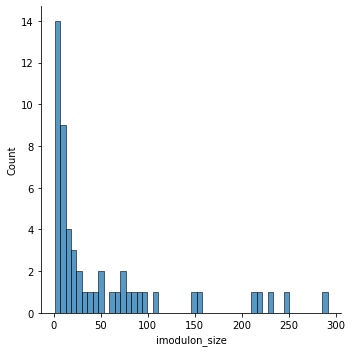

In [83]:
sns.displot(ica_data.imodulon_table['imodulon_size'],bins=50)

In [84]:
import matplotlib.pyplot as plt

(array([0.11320755, 0.28301887, 0.52830189, 0.58490566, 0.62264151,
        0.66037736, 0.66037736, 0.67924528, 0.69811321, 0.73584906,
        0.75471698, 0.75471698, 0.77358491, 0.79245283, 0.79245283,
        0.83018868, 0.83018868, 0.8490566 , 0.8490566 , 0.90566038,
        0.90566038, 0.90566038, 0.9245283 , 0.9245283 , 0.9245283 ,
        0.9245283 , 0.96226415, 0.98113208, 0.98113208, 1.        ]),
 array([0.00056521, 0.00284647, 0.00512772, 0.00740898, 0.00969024,
        0.0119715 , 0.01425275, 0.01653401, 0.01881527, 0.02109653,
        0.02337778, 0.02565904, 0.0279403 , 0.03022156, 0.03250281,
        0.03478407, 0.03706533, 0.03934659, 0.04162784, 0.0439091 ,
        0.04619036, 0.04847162, 0.05075287, 0.05303413, 0.05531539,
        0.05759665, 0.0598779 , 0.06215916, 0.06444042, 0.06672168,
        0.06900293]),
 <BarContainer object of 30 artists>)

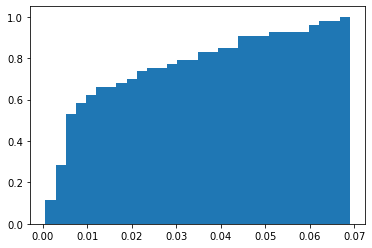

In [85]:
x = ica_data.imodulon_table.sort_values('explained_variance',ascending=False)['explained_variance']
plt.hist(x,cumulative=True, density=True, bins=30)

<AxesSubplot:xlabel='explained_variance', ylabel='Proportion'>

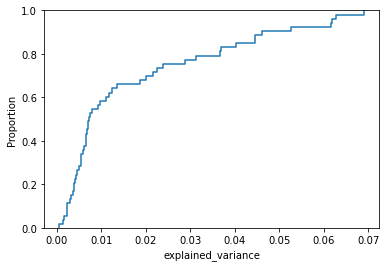

In [86]:
sns.ecdfplot(data=ica_data.imodulon_table, x='explained_variance')

In [87]:
ica_data.imodulon_table.sort_values('explained_variance',ascending=False)

,single_gene,imodulon_size,explained_variance
36,NaN,26.0,0.069003
41,NaN,291.0,0.062863
31,NaN,25.0,0.061955
21,NaN,15.0,0.061652
39,NaN,221.0,0.052555
27,NaN,9.0,0.046064
22,NaN,12.0,0.044637
14,NaN,50.0,0.044466
5,NaN,62.0,0.040222
17,NaN,68.0,0.036859


Text(0, 0.5, 'Explained Variance')

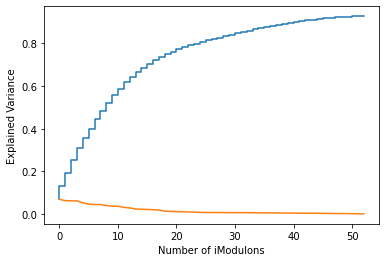

In [88]:
cx = list(zip(*enumerate(np.cumsum(x.values))))
plt.step(cx[0],cx[1])
plt.plot(x.values)
plt.xlabel('Number of iModulons')
plt.ylabel('Explained Variance')

In [99]:
cx

[(0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52),
 (0.06900293360178733,
  0.13186566125842858,
  0.19382070546941632,
  0.25547260592837007,
  0.30802756844927326,
  0.35409204936484673,
  0.39872904904680995,
  0.44319499784782557,
  0.48341716573710525,
  0.5202758272757789,
  0.5568596401200444,
  0.5881076859878112,
  0.6169245396883141,
  0.6407374863728557,
  0.6632552851749799,
  0.6847728189611682,
  0.7047833053054777,
  0.7235195825889619,
  0.7369543341035721,
  0.7494098392600217,
  0.7610593267152335,
  0.7720206833869252,
  0.7816843772343716,
  0.7910142361951336,
  0.7987969995833951,
  0.8061570808269352,
  0.8132891165357967,
  0.8202750341451913,
  0.8271614487352753,
  0.8338218324299979,
  0.840398360425623,
 

<AxesSubplot:xlabel='imodulon_size', ylabel='explained_variance'>

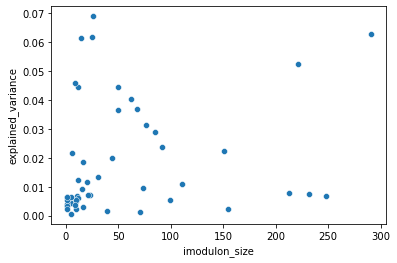

In [89]:
sns.scatterplot(data=ica_data.imodulon_table, x='imodulon_size',y='explained_variance')

In [90]:
import altair as alt

In [94]:
idx=29
ica_data.view_imodulon(idx)[['product','gene_weight','tu_name','gene_name_extra']]

,product,gene_weight,tu_name,gene_name_extra
EQU24_RS00105,cAMP-activated global transcriptional regulato...,-0.031130,crp // EQU24_RS00100,crp||crp
EQU24_RS00145,hypothetical protein,-0.035153,EQU24_RS00155 // EQU24_RS00150 // EQU24_RS00145,||None
EQU24_RS00190,hypothetical protein,0.038314,EQU24_RS00195 // EQU24_RS00190,||None
EQU24_RS00195,DUF4338 domain-containing protein,0.033967,EQU24_RS00195 // EQU24_RS00190,||None
EQU24_RS00205,IS66 family transposase,0.049202,EQU24_RS00205,||None
...,...,...,...,...
EQU24_RS21750,DUF3450 domain-containing protein,-0.057395,EQU24_RS21750 // EQU24_RS21745 // EQU24_RS2174...,||None
EQU24_RS21760,amidohydrolase,-0.037305,EQU24_RS21760,||doeB2
EQU24_RS21865,type II toxin-antitoxin system HicB family ant...,0.032338,EQU24_RS21870 // EQU24_RS21865 // EQU24_RS21860,||None
EQU24_RS21910,MotA/TolQ/ExbB proton channel family protein,-0.033401,EQU24_RS21915 // EQU24_RS21910 // EQU24_RS21905,||None


In [95]:
DF_enrichments[DF_enrichments['imodulon']==idx]

,imodulon,go_name,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,annotation,pathway_name,module_name
129,29,sulfate transmembrane transport,0.000003,0.011323,0.028169,0.6,0.053812,6.0,10.0,213.0,GO,NaN,NaN,NaN
130,29,ABC-type sulfate transporter activity,0.000006,0.013048,0.018779,1.0,0.036866,4.0,4.0,213.0,GO,NaN,NaN,NaN
38,29,NaN,0.000006,0.002162,0.018779,1.0,0.036866,4.0,4.0,213.0,KEGG modules,M00185,NaN,None


In [96]:
ica_data.imodulon_table[ica_data.imodulon_table.index ==idx]

,single_gene,imodulon_size,explained_variance
29,NaN,213.0,0.007783
